<a href="https://colab.research.google.com/github/Marcusleeleelee/FTEC4998-4999/blob/main/FTEC4998_4999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn models and utilities
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Scikit-learn utilities
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.utils import resample

# PyTorch for neural network models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Progress bar for loops
from tqdm import tqdm

# Plotting accuracy curves and other metrics
import matplotlib.pyplot as plt

# Others

# Google Colab specific (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
class Dataset:
    def __init__(self, file_path):
        self.dataset = pd.read_feather(file_path)
        self.original = self.dataset.copy()
        self.X_train, self.y_train = None, None
        self.X_valid, self.y_valid = None, None
        self.X_test, self.y_test = None, None
        self.label = 'loan_condition_cat'
        self.min_max_columns = ['annual_inc', 'year']
        self.means = {}
        self.stds = {}
        self.mins = {}
        self.maxs = {}

    def show(self, rows=10):
        return self.dataset.head(rows)

    def basic_processing(self):
        temp_func_2 = lambda x: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}[str(x)]
        columns_to_delete = [
            'id', 'issue_d', 'home_ownership_cat', 'income_category', 'income_cat', 'term_cat',
            'application_type_cat', 'purpose_cat', 'interest_payment_cat', 'loan_condition'
        ]
        self.dataset.drop(columns=columns_to_delete, inplace=True)
        self.dataset['grade'] = self.dataset['grade'].apply(temp_func_2)
        self.dataset['final_d'] = self.dataset['final_d'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset['year'] = self.dataset['year'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset = pd.get_dummies(self.dataset, columns=['home_ownership', 'term', 'application_type',
                                                             'purpose', 'interest_payments', 'region'], dtype=int)

    def train_test_split(self, test_size=0.2, valid_size=0.2, random_state=42):
        # Split into train and test first
        X = self.dataset.drop(columns=[self.label])
        y = self.dataset[self.label]
        X_train_full, self.X_test, y_train_full, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Further split training data into training and validation sets
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train_full, y_train_full, test_size=valid_size, random_state=random_state)

        # Save original columns for reference
        self.original_columns = X.columns

        # Sort and reset index for consistency
        for dataset in [self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test]:
            dataset.sort_index(inplace=True)
            dataset.reset_index(drop=True, inplace=True)

    def preprocessing_train(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_train.columns if col not in columns_to_normalize]

        # Z-score normalization
        for col in columns_to_scale:
            mean = np.mean(self.X_train[col])
            std = np.std(self.X_train[col])
            self.means[col] = mean
            self.stds[col] = std
            self.X_train[col] = (self.X_train[col] - mean) / std

        # Min-Max normalization
        for col in columns_to_normalize:
            min_val = np.min(self.X_train[col])
            max_val = np.max(self.X_train[col])
            self.mins[col] = min_val
            self.maxs[col] = max_val
            self.X_train[col] = (self.X_train[col] - min_val) / (max_val - min_val)

        # Perform PCA
        selected_columns = self.perform_pca(self.X_train, n_components=35)
        self.X_train = self.X_train[selected_columns]

    def perform_pca(self, data, n_components):
        # Center the data
        data_mean = np.mean(data, axis=0)
        centered_data = data - data_mean

        # Compute covariance matrix
        cov_matrix = np.cov(centered_data, rowvar=False)

        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Select the top n_components
        selected_eigenvectors = sorted_eigenvectors[:, :n_components]

        # Identify important features
        feature_importance = np.abs(selected_eigenvectors).sum(axis=1)
        important_indices = np.argsort(feature_importance)[::-1][:n_components]

        # Return the original column names of these features
        important_features = [self.original_columns[i] for i in important_indices]

        return important_features

    def preprocessing_test(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_test.columns if col not in columns_to_normalize]

        # Apply Z-score normalization using training statistics
        for col in columns_to_scale:
            self.X_test[col] = (self.X_test[col] - self.means[col]) / self.stds[col]

        # Apply Min-Max normalization using training statistics
        for col in columns_to_normalize:
            self.X_test[col] = (self.X_test[col] - self.mins[col]) / (self.maxs[col] - self.mins[col])

        # Apply PCA using training components
        self.X_test = self.X_test[[i for i in self.X_train.columns.to_list()]]

    def preprocessing_valid(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_valid.columns if col not in columns_to_normalize]

        # Apply Z-score normalization using training statistics
        for col in columns_to_scale:
            self.X_valid[col] = (self.X_valid[col] - self.means[col]) / self.stds[col]

        # Apply Min-Max normalization using training statistics
        for col in columns_to_normalize:
            self.X_valid[col] = (self.X_valid[col] - self.mins[col]) / (self.maxs[col] - self.mins[col])

        # Apply PCA using training components
        self.X_valid = self.X_valid[[i for i in self.X_train.columns.to_list()]]

In [23]:
# Calculating # ok
data = Dataset('/content/drive/My Drive/Colab Notebooks/FTEC4998_9/loan_final313_processed.feather')
data.basic_processing()
data.train_test_split(test_size=0.15, valid_size=0.15)
data.preprocessing_train()
data.preprocessing_valid()
data.preprocessing_test()

In [24]:
# Data conversion
train_x, train_y = data.X_train, data.y_train
valid_x, valid_y = data.X_valid, data.y_valid
test_x, test_y = data.X_test, data.y_test

# Print the percentage of positive class in the training set
counts = np.mean(train_y == 1) * 100
print(f"{counts:.2f}% of the training set belongs to the positive class.")

# Print the shapes of the datasets
print(f"Training set shape: {train_x.shape}, {train_y.shape}")
print(f"Validation set shape: {valid_x.shape}, {valid_y.shape}")
print(f"Test set shape: {test_x.shape}, {test_y.shape}")

# Print the types of the datasets
print(f"Training type: {type(train_x)}, {type(train_y)}")
print(f"Validation type: {type(valid_x)}, {type(valid_y)}")
print(f"Test type: {type(test_x)}, {type(test_y)}")

# Ensure y_train, y_valid, and y_test are binary
assert set(train_y).issubset({0, 1}), "Target values for train_y must be 0 or 1 for binary classification."
assert set(valid_y).issubset({0, 1}), "Target values for valid_y must be 0 or 1 for binary classification."
assert set(test_y).issubset({0, 1}), "Target values for test_y must be 0 or 1 for binary classification."

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

7.61% of the training set belongs to the positive class.
Training set shape: (641131, 35), (641131,)
Validation set shape: (113141, 35), (113141,)
Test set shape: (133107, 35), (133107,)
Training type: <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>
Validation type: <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>
Test type: <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>


In [25]:
# Train, predict, and accuracy functions
# Function to train the model and store the loss trajectory
def train_model_with_loss_tracking(model, train_x, train_y):
    """
    Train the model, track the loss at each epoch, and return the loss history.
    """
    loss_history = []

    # Loop over the number of epochs
    for epoch in range(model.epochs):
        model.train()  # Set the model to training mode

        # Forward pass
        output = model(train_x)
        loss = model.criterion(output, train_y)

        # Backward pass and optimization
        model.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        model.optimizer.step()  # Update the weights

        # Save the loss for this epoch
        loss_history.append(loss.item())

        # Print loss every 50 epochs for tracking
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{model.epochs}], Loss: {loss.item():.4f}')

    return loss_history

def predict_model_pt(model, X): # ok
    if isinstance(X, pd.DataFrame): X = torch.tensor(X.to_numpy(), dtype=torch.float32)  # Convert DataFrame to tensor
    X = X.to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        outputs = model(X).squeeze()
        return (outputs > 0.5).float().cpu().numpy()  # Convert to numpy array for output

def calculate_accuracy_pt(model, X, y, pred=None): # 95% ok
    # Ensure X and y are on the same device as the model

    if str(type(X)) != "<class 'torch.Tensor'>": X, y = df_to_tensor(X, y)

    # Get predictions
    predictions = torch.tensor(predict_model_pt(model, X), dtype=torch.float32).to(device) if pred is None else torch.tensor(pred, dtype=torch.float32).to(device)

    # Ensure predictions and labels are the same shape
    predictions = predictions.squeeze()
    y = y.squeeze()

    # Calculate accuracy
    correct = (predictions == y).sum().item()
    accuracy = correct / len(y)
    return accuracy

# Function to calculate precision, recall, and AUC
def evaluate_metrics(model, X, y):
    # Evaluate precision, recall, and AUC for a given model and dataset.
    # Get the predicted probabilities (before the 0.5 threshold)
    X, y = df_to_tensor(X, y)
    y_proba = model(X).cpu().detach().numpy()

    # Get binary predictions using the threshold of 0.5
    y_pred = (y_proba > 0.5).astype(float)
    y_true = y.cpu().numpy()

    # Calculate precision, recall, and AUC
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    return precision, recall, auc

def df_to_tensor(x, y, device=device): # ok
    assert isinstance(x, pd.DataFrame) and isinstance(y, pd.Series), str((type(x), type(y)))
    return (torch.tensor(x.to_numpy(), dtype=torch.float32).to(device),  torch.tensor(y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device))

Epoch [50/600], Loss: 0.1977
Epoch [100/600], Loss: 0.1689
Epoch [150/600], Loss: 0.1634
Epoch [200/600], Loss: 0.1614
Epoch [250/600], Loss: 0.1605
Epoch [300/600], Loss: 0.1601
Epoch [350/600], Loss: 0.1598
Epoch [400/600], Loss: 0.1596
Epoch [450/600], Loss: 0.1595
Epoch [500/600], Loss: 0.1594
Epoch [550/600], Loss: 0.1593
Epoch [600/600], Loss: 0.1592
Validation Accuracy: 0.94936
Validation Precision: 0.8713
Validation Recall: 0.38394
Validation AUC: 0.89446


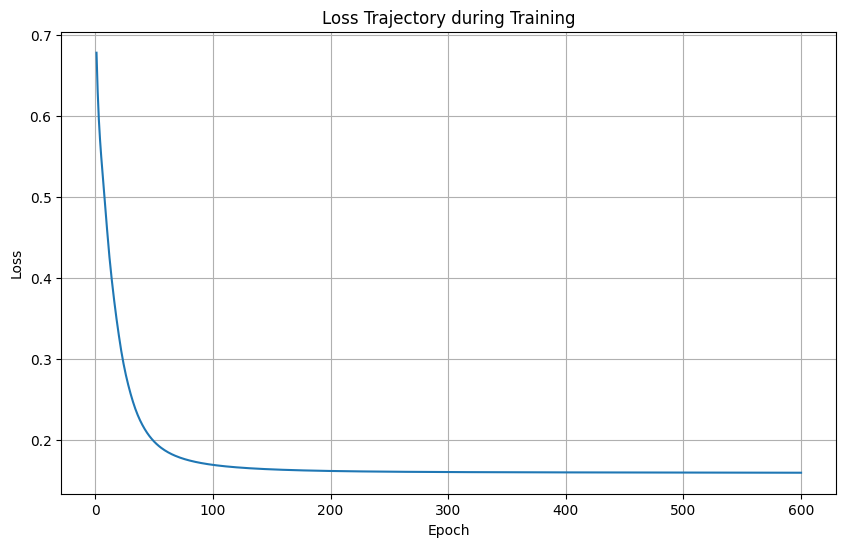

In [28]:
# Required imports for precision, recall, AUC, and plotting
import matplotlib.pyplot as plt

# Define the Logistic Regression model as a simple neural network
class LogisticRegressionModel(nn.Module):
    def __init__(self, train_x, train_y, lr=0.05):
        super(LogisticRegressionModel, self).__init__()

        # Convert training data to tensors and move to the specified device (GPU/CPU)
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)

        # Set input dimension based on the number of features in train_x
        self.input_dim = self.train_x.shape[1]

        # Define the neural network architecture: One Linear layer followed by a Sigmoid activation
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 1),  # Linear layer mapping input to one output
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

        # Define the loss function (Binary Cross-Entropy) and the optimizer (Adam)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Set the number of training epochs
        self.epochs = 600

    def forward(self, x):
        """
        Forward pass: Compute the output of the network given input x.
        """
        return self.net(x)

# Instantiate the Logistic Regression model
lrg_model = LogisticRegressionModel(train_x, train_y)

# Move the model to the specified device (GPU or CPU)
lrg_model.to(device)

# Train the model and track loss trajectory
loss_history = train_model_with_loss_tracking(lrg_model, lrg_model.train_x, lrg_model.train_y)

# Make predictions on the validation set
pred_valid = predict_model_pt(lrg_model, valid_x)

# Calculate validation accuracy
accuracy_valid = calculate_accuracy_pt(lrg_model, valid_x, valid_y, pred_valid)

# Calculate precision, recall, and AUC for the validation set
precision_valid, recall_valid, auc_valid = evaluate_metrics(lrg_model, valid_x, valid_y)

# Print validation metrics
print('Validation Accuracy:', round(accuracy_valid, 5))
print('Validation Precision:', round(precision_valid, 5))
print('Validation Recall:', round(recall_valid, 5))
print('Validation AUC:', round(auc_valid, 5))

# Plot the loss trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(1, lrg_model.epochs + 1), loss_history, linestyle='-')
plt.title('Loss Trajectory during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Epoch [50/600], Loss: 0.1447
Epoch [100/600], Loss: 0.1252
Epoch [150/600], Loss: 0.1116
Epoch [200/600], Loss: 0.1069
Epoch [250/600], Loss: 0.1058
Epoch [300/600], Loss: 0.1065
Epoch [350/600], Loss: 0.1067
Epoch [400/600], Loss: 0.1052
Epoch [450/600], Loss: 0.1036
Epoch [500/600], Loss: 0.1045
Epoch [550/600], Loss: 0.1031
Epoch [600/600], Loss: 0.1039
Validation Accuracy: 0.9607
Validation Precision: 0.94805
Validation Recall: 0.50569
Validation AUC: 0.9592


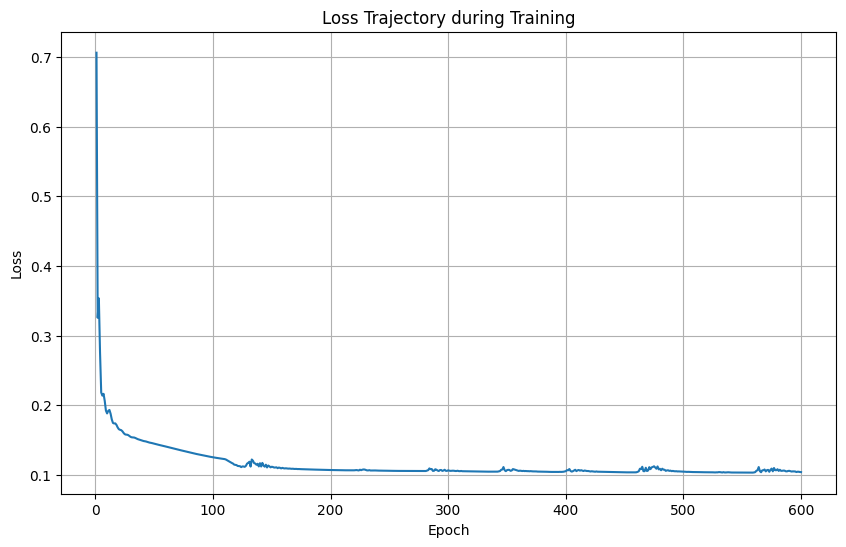

In [29]:
# Required imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the MLP model for binary classification
class MLPModel(nn.Module):
    def __init__(self, train_x, train_y, lr=0.05):
        super(MLPModel, self).__init__()

        # Convert training data to tensors and move to the specified device (GPU/CPU)
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)

        # Set input dimension based on the number of features in train_x
        self.input_dim = self.train_x.shape[1]

        # Define the MLP architecture
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        # Define the loss function (Binary Cross-Entropy) and the optimizer (Adam)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Set the number of training epochs
        self.epochs = 600

    def forward(self, x):
        """
        Forward pass: Compute the output of the network given input x.
        """
        return self.net(x)

    def plot_model_architecture(self):
        """
        Plots the architecture of the PyTorch model by visualizing the layers.

        Args:
        - model: A PyTorch model (should be nn.Sequential or contain a sequential-like structure).
        """
        # Extract layers from the model (assuming it's a nn.Sequential model)
        layers = []
        for layer in self.model.net:
            layers.append(str(layer))

        # Define the number of layers and nodes in each layer
        num_layers = len(layers)

        # Create a figure
        plt.figure(figsize=(8, 6))
        plt.title('MLP Model Architecture', fontsize=16)

        # Plotting the layers
        y_offset = 0
        for i, layer in enumerate(layers):
            layer_name = layer.split('(')[0]  # Get the layer name (Linear, ReLU, etc.)

            # Plot the layer type as text
            plt.text(0.5, y_offset, layer_name, fontsize=12, ha='center')

            # Draw a rectangle for each layer to represent it visually
            plt.gca().add_patch(plt.Rectangle((0.3, y_offset - 0.2), 0.4, 0.4, fill=True, edgecolor='black', facecolor='lightgray'))

            # Update y_offset for the next layer
            y_offset -= 1.0

        # Adjust plot limits and hide axes
        plt.gca().set_xlim(0, 1)
        plt.gca().set_ylim(y_offset + 0.5, 0.5)
        plt.gca().axis('off')

        # Show the plot
        plt.show()

# Instantiate the MLP model
mlp_model = MLPModel(train_x, train_y)

# Move the model to the specified device (GPU or CPU)
mlp_model.to(device)

# Train the model and track loss trajectory
loss_history = train_model_with_loss_tracking(mlp_model, mlp_model.train_x, mlp_model.train_y)

# Make predictions on the validation set
pred_valid = predict_model_pt(mlp_model, valid_x)

# Calculate validation accuracy
accuracy_valid = calculate_accuracy_pt(mlp_model, valid_x, valid_y, pred_valid)

# Calculate precision, recall, and AUC for the validation set
precision_valid, recall_valid, auc_valid = evaluate_metrics(mlp_model, valid_x, valid_y)

# Print validation metrics
print('Validation Accuracy:', round(accuracy_valid, 5))
print('Validation Precision:', round(precision_valid, 5))
print('Validation Recall:', round(recall_valid, 5))
print('Validation AUC:', round(auc_valid, 5))

# Plot the loss trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(1, mlp_model.epochs + 1), loss_history, linestyle='-')
plt.title('Loss Trajectory during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot model architecture
mlp_model.plot_model_architecture()

Epoch 0, Loss: 0.9161598682403564
Epoch 50, Loss: 0.8374332785606384
Epoch 100, Loss: 0.772408127784729
Epoch 150, Loss: 0.7173776030540466
Epoch 200, Loss: 0.6708447933197021
Epoch 250, Loss: 0.6318569183349609
Epoch 300, Loss: 0.5991731286048889
Epoch 350, Loss: 0.5716618895530701
Epoch 400, Loss: 0.5482798218727112
Epoch 450, Loss: 0.5279086232185364
Epoch 500, Loss: 0.5097042322158813
Epoch 550, Loss: 0.4931057393550873
Train pred: [1. 0. 0. ... 0. 0. 0.]
Train acc: 0.9167440039555099
Valid pred: [1. 0. 1. ... 0. 0. 0.]
Valid acc: 0.9171211143617256
Test pred: [0. 0. 1. ... 0. 0. 0.]
Test acc: 0.9165483408085224


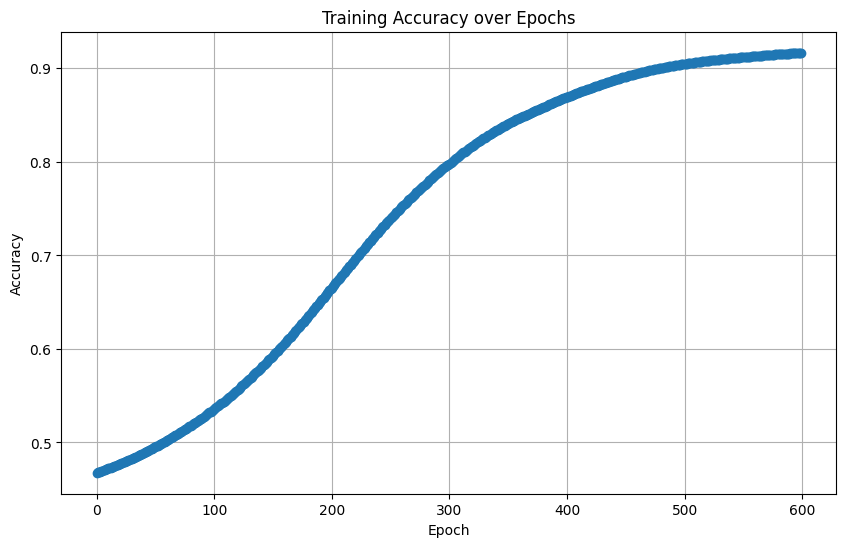

In [ ]:
# Logistic Regression as a neural network
class LogisticRegressionModel(nn.Module): # Not yet finish the plot function
    def __init__(self, train_x, train_y, lr=0.001):
        super(LogisticRegressionModel, self).__init__()
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)
        self.input_dim = self.train_x.shape[1]
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 1),
            nn.Sigmoid()
        )
        self._initialize_weights()
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.epochs = 600

    def forward(self, x):
        return self.net(x)
    def _initialize_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

lrg = LogisticRegressionModel(train_x, train_y)
lrg.to(device)
ABC = train_model_pt(lrg)
pred_train = predict_model_pt(lrg, train_x)
accuracy_train = calculate_accuracy_pt(lrg, train_x, train_y, pred_train)
pred_valid = predict_model_pt(lrg, valid_x)
accuracy_valid = calculate_accuracy_pt(lrg, valid_x, valid_y, pred_valid)
pred_test = predict_model_pt(lrg, test_x)
accuracy_test = calculate_accuracy_pt(lrg, test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)
# Extract epochs and accuracies
epochs = list(ABC.keys())
accuracies = list(ABC.values())

# Plotting accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', linestyle='-')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
# Oblivious Decision Tree model
class ObliviousDecisionTree(nn.Module):
    def __init__(self, train_x, train_y, depth=6, lr=0.01, epochs=50, optimizer_type='adam', loss_fn='mse', lr_scheduler=None):
        super(ObliviousDecisionTree, self).__init__()
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)
        self.input_dim = self.train_x.shape[1]
        self.depth = depth

        # Initialize feature selectors and thresholds for each depth level
        self.feature_selectors = nn.ParameterList(
            [nn.Parameter(torch.randn(self.input_dim)) for _ in range(depth)]
        )
        self.thresholds = nn.ParameterList(
            [nn.Parameter(torch.randn(1)) for _ in range(depth)]
        )

        # Initialize leaf values (2^depth leaves)
        self.leaf_values = nn.Parameter(torch.randn(2 ** depth))

        # Loss Function
        if loss_fn == 'mse': self.criterion = nn.MSELoss()
        elif loss_fn == 'bce': self.criterion = nn.BCELoss()
        else: raise ValueError("Unsupported loss function. Use 'mse' or 'bce'.")

        # Optimizer
        if optimizer_type == 'adam': self.optimizer = optim.Adam(self.parameters(), lr=lr)
        elif optimizer_type == 'sgd': self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        else: raise ValueError("Unsupported optimizer type. Use 'adam' or 'sgd'.")

        # Learning Rate Scheduler (optional)
        self.lr_scheduler = None
        if lr_scheduler == 'step': self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        elif lr_scheduler == 'plateau': self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')

        # Number of training epochs
        self.epochs = epochs

    def forward(self, x):
        batch_size = x.size(0)
        node_indices = torch.zeros(batch_size, dtype=torch.long).to(x.device)

        for d in range(self.depth):
            feature_selector = self.feature_selectors[d]
            threshold = self.thresholds[d]
            feature_value = torch.matmul(x, feature_selector)
            go_right = feature_value > threshold
            node_indices = (node_indices << 1) | go_right.long()
        return self.leaf_values[node_indices].unsqueeze(1)
odt = ObliviousDecisionTree(train_x, train_y, depth=3, lr=0.01, epochs=500, optimizer_type='adam', loss_fn='mse', lr_scheduler='step')
odt.to(device)
train_model_pt(odt)
pred_train = predict_model_pt(odt, train_x)
accuracy_train = calculate_accuracy_pt(odt, train_x, train_y, pred_train)
pred_valid = predict_model_pt(odt, valid_x)
accuracy_valid = calculate_accuracy_pt(odt, valid_x, valid_y, pred_valid)
pred_test = predict_model_pt(odt, test_x)
accuracy_test = calculate_accuracy_pt(odt, test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)

Epoch 0, Loss: 1.141756296157837
Epoch 5, Loss: 1.0622385740280151
Epoch 10, Loss: 0.9878339171409607
Epoch 15, Loss: 0.9178289175033569
Epoch 20, Loss: 0.8519766330718994
Epoch 25, Loss: 0.790435254573822
Epoch 30, Loss: 0.7329530119895935
Epoch 35, Loss: 0.6791958212852478
Epoch 40, Loss: 0.6289980411529541
Epoch 45, Loss: 0.582176923751831
Epoch 50, Loss: 0.5385658740997314
Epoch 55, Loss: 0.49804726243019104
Epoch 60, Loss: 0.4604746401309967
Epoch 65, Loss: 0.42569631338119507
Epoch 70, Loss: 0.39356255531311035
Epoch 75, Loss: 0.3639194965362549
Epoch 80, Loss: 0.33662155270576477
Epoch 85, Loss: 0.31152424216270447
Epoch 90, Loss: 0.2884862422943115
Epoch 95, Loss: 0.2673698961734772
Epoch 100, Loss: 0.24804306030273438
Epoch 105, Loss: 0.23037898540496826
Epoch 110, Loss: 0.21425725519657135
Epoch 115, Loss: 0.1995640993118286
Epoch 120, Loss: 0.18619200587272644
Epoch 125, Loss: 0.1740388572216034
Epoch 130, Loss: 0.16300968825817108
Epoch 135, Loss: 0.15301498770713806
Epoch 

In [ ]:
# SVM
class SVMClassifier():
    def __init__(self, train_x, train_y, fraction=0.1, C=0.1, kernel='poly', degree=3, gamma='scale', n_estimators=6, max_samples=0.001, random_state=42):
        """
        Initialize the SVMClassifier with training data and optional parameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - fraction: Fraction of data to sample (not used in this implementation).
        - C: Penalty parameter C of the error term for SVM.
        - kernel: Kernel type to be used in the SVM algorithm.
        - degree: Degree of the polynomial kernel function (if kernel='poly').
        - gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'.
        - n_estimators: The number of base estimators in the Bagging ensemble.
        - max_samples: The number of samples to draw from X to train each base estimator.
        - random_state: Controls the randomness of the bootstrapping of the samples.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state

        self.model = None
        self.accuracies = []

    def fit(self):
        """Fits the SVM model using Bagging with the specified parameters."""
        self.model = BaggingClassifier(
            estimator=SVC(C=self.C, kernel=self.kernel, degree=self.degree, gamma=self.gamma),
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            random_state=self.random_state
        )
        self.model.fit(self.train_x, self.train_y)
        self._update_accuracy()

    def _update_accuracy(self):
        """Internal method to update and store the model's accuracy on the training set."""
        predictions = self.model.predict(self.train_x)
        accuracy = accuracy_score(self.train_y, predictions)
        self.accuracies.append(accuracy)

    def predict(self, X):
        """Predicts the labels for the given input data X."""
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict`.")
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        """Calculates the accuracy of the model on the given data X and true labels y."""
        if pred is None: pred = self.predict(X)
        return accuracy_score(y, pred)

    def plot_training_curve(self):
        """Plots the training accuracy curve after fitting the model."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('SVM Training Accuracy Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()

svm = SVMClassifier(train_x, train_y)
svm.fit()
pred_train = svm.predict(train_x)
accuracy_train = svm.calculate_accuracy(train_x, train_y, pred_train)
pred_valid = svm.predict(valid_x)
accuracy_valid = svm.calculate_accuracy(valid_x, valid_y, pred_valid)
pred_test = svm.predict(test_x)
accuracy_test = svm.calculate_accuracy(test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)

Train pred: [0. 0. 0. ... 0. 0. 0.]
Train acc: 0.9288398158878607
Valid pred: [0. 0. 0. ... 0. 0. 0.]
Valid acc: 0.9298309189418513
Test pred: [0. 0. 0. ... 0. 0. 0.]
Test acc: 0.9290270233721742


In [ ]:
# NB
class NaiveBayesClassifier():
    def __init__(self, train_x, train_y):
        """
        Initialize the NaiveBayesClassifier with training data and model parameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - priors: Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
        - var_smoothing: Portion of the largest variance of all features that is added to variances for stability.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.accuracies = []

        self.model = GaussianNB()

    def fit(self):
        """Fit the Naive Bayes model on the training data and track training accuracy."""
        self.model.fit(self.train_x, self.train_y)
        accuracy = self._calculate_accuracy_internal(self.train_x, self.train_y)
        self.accuracies.append(accuracy)

    def _calculate_accuracy_internal(self, X, y):
        """Internal method to predict and calculate accuracy on the training data."""
        predictions = self.model.predict(X)
        return accuracy_score(y, predictions)

    def predict(self, X):
        """Predict the labels for the input features X."""
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict`.")
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        """
        Calculate the accuracy of the model on the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.
        - pred: Precomputed predictions (optional).

        Returns:
        - accuracy: Accuracy of the predictions.
        """
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        return accuracy_score(y, predictions)

    def plot_training_curve(self):
        """Plot the training accuracy curve after fitting the model."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('Naive Bayes Training Accuracy Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
nb = NaiveBayesClassifier(train_x, train_y)
nb.fit()
pred_train = nb.predict(train_x)
accuracy_train = nb.calculate_accuracy(train_x, train_y, pred_train)
pred_valid = nb.predict(valid_x)
accuracy_valid = nb.calculate_accuracy(valid_x, valid_y, pred_valid)
pred_test = nb.predict(test_x)
accuracy_test = nb.calculate_accuracy(test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)

Train pred: [1. 0. 0. ... 0. 0. 0.]
Train acc: 0.9322993272825678
Valid pred: [1. 0. 0. ... 0. 0. 0.]
Valid acc: 0.9330393049380861
Test pred: [0. 0. 1. ... 0. 0. 0.]
Test acc: 0.9322800453770275


In [ ]:
# RF
class RandomForestModel():
    def __init__(self, train_x, train_y, n_estimators=10, max_depth=None, random_state=42, max_samples=0.05, warm_start=True):
        """
        Initialize the RandomForestModel with training data and hyperparameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - n_estimators: The number of trees in the forest.
        - max_depth: The maximum depth of the tree.
        - random_state: Controls the randomness of the estimator.
        - max_samples: The number of samples to draw from X to train each base estimator.
        - warm_start: When set to True, reuse the solution of the previous call to fit.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.accuracies = []

        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            max_samples=max_samples,
            warm_start=warm_start
        )

    def fit(self):
        """Fit the RandomForest model on the training data, tracking accuracy at each step."""
        for i in range(1, self.model.n_estimators + 1):
            self.model.n_estimators = i
            self.model.fit(self.train_x, self.train_y)
            accuracy = self._calculate_accuracy_internal(self.train_x, self.train_y)
            self.accuracies.append(accuracy)

    def _calculate_accuracy_internal(self, X, y):
        """Internal method to predict and calculate accuracy on the training data."""
        predictions = self.model.predict(X)
        return accuracy_score(y, predictions)

    def predict(self, X):
        """Predict the labels for the input features X."""
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict`.")
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        """
        Calculate the accuracy of the model on the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.
        - pred: Precomputed predictions (optional).

        Returns:
        - accuracy: Accuracy of the predictions.
        """
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        return accuracy_score(y, predictions)

    def plot_training_curve(self):
        """Plot the training accuracy curve based on the number of trees in the forest."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('Random Forest Training Accuracy Curve')
        plt.xlabel('Number of Trees')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
rf = RandomForestModel(train_x, train_y)
rf.fit()
pred_train = rf.predict(train_x)
accuracy_train = rf.calculate_accuracy(train_x, train_y, pred_train)
pred_valid = rf.predict(valid_x)
accuracy_valid = rf.calculate_accuracy(valid_x, valid_y, pred_valid)
pred_test = rf.predict(test_x)
accuracy_test = rf.calculate_accuracy(test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)

Train pred: [1. 0. 0. ... 0. 0. 0.]
Train acc: 0.9580304181204777
Valid pred: [0. 0. 0. ... 0. 0. 0.]
Valid acc: 0.9578137014875244
Test pred: [0. 0. 1. ... 0. 0. 0.]
Test acc: 0.9568242090949387


In [ ]:
#XBG
class XGBoostClassifier():
    def __init__(self, train_x, train_y, n_estimators=100, learning_rate=0.1, max_depth=6,
                 subsample=0.8, colsample_bytree=0.8, gamma=0, reg_alpha=0, reg_lambda=1, eval_metric='error'):
        """
        Initialize the XGBoostClassifier with training data and hyperparameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - n_estimators: Number of trees in the ensemble.
        - learning_rate: Step size shrinkage used to prevent ovexgbitting.
        - max_depth: Maximum depth of a tree.
        - subsample: Subsample ratio of the training instances.
        - colsample_bytree: Subsample ratio of columns when constructing each tree.
        - gamma: Minimum loss reduction required to make a further partition.
        - reg_alpha: L1 regularization term on weights.
        - reg_lambda: L2 regularization term on weights.
        - eval_metric: Evaluation metric for cross-validation (default is 'error').
        """
        self.train_x = train_x
        self.train_y = train_y

        self.model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric=eval_metric
        )

    def fit(self):
        """Fit the XGBoost model on the training data."""
        self.model.fit(
            self.train_x, self.train_y,
            eval_set=[(self.train_x, self.train_y)],
            verbose=False
        )

    def predict(self, X):
        """Predict the labels for the input features X."""
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict`.")
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        """
        Calculate the accuracy of the model on the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.
        - pred: Precomputed predictions (optional).

        Returns:
        - accuracy: Accuracy of the predictions.
        """
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        return accuracy_score(y, predictions)

    def plot_training_curve(self):
        """Plot the training accuracy curve based on the model's evaluation results."""
        evals_result = self.model.evals_result()
        error_values = evals_result['validation_0']['error']
        accuracy_values = [1 - e for e in error_values]  # Convert error to accuracy
        epochs = len(accuracy_values)
        x_axis = range(epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, accuracy_values, marker='o', linestyle='-')
        plt.title('XGBoost Training Accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
xgb = XGBoostClassifier(train_x, train_y)
xgb.fit()
pred_train = xgb.predict(train_x)
accuracy_train = xgb.calculate_accuracy(train_x, train_y, pred_train)
pred_valid = xgb.predict(valid_x)
accuracy_valid = xgb.calculate_accuracy(valid_x, valid_y, pred_valid)
pred_test = xgb.predict(test_x)
accuracy_test = xgb.calculate_accuracy(test_x, test_y, pred_test)
print('Train pred:', pred_train)
print('Train acc:', accuracy_train)
print('Valid pred:', pred_valid)
print('Valid acc:', accuracy_valid)
print('Test pred:', pred_test)
print('Test acc:', accuracy_test)

Train pred: [1. 0. 0. ... 0. 0. 0.]
Train acc: 0.960472976661556
Valid pred: [0. 0. 0. ... 0. 0. 0.]
Valid acc: 0.9611193113018269
Test pred: [0. 0. 1. ... 0. 0. 0.]
Test acc: 0.9603627157099176


In [ ]:
# @title Testing
# class TabPFNBagging():
#     def __init__(self, train_x, train_y, n_estimators=10, sample_size=1000, device=device, N_ensemble_configurations=1):
#         self.train_x = train_x
#         self.train_y = train_y
#         self.n_estimators = n_estimators
#         self.sample_size = sample_size
#         self.device = device
#         self.N_ensemble_configurations = N_ensemble_configurations
#         self.models = []
#         self.X_sample, self.y_sample = None, None

#     def fit(self):
#         for i in range(self.n_estimators):
#             print(f"Training estimator {i + 1}/{self.n_estimators}...")
#             self.X_sample, self.y_sample = resample(self.train_x, self.train_y, n_samples=self.sample_size)
#             model = TabPFNClassifier(device=self.device, N_ensemble_configurations=self.N_ensemble_configurations)
#             model.fit(self.X_sample, self.y_sample, overwrite_warning=True)
#             self.models.append(model)
#         print("Bagging model training complete.")

#     def predict(self, X, batch_size=9000):
#         n_samples = X.shape[0]
#         n_batches = int(np.ceil(n_samples / batch_size))

#         # Initialize predictions array
#         predictions = np.zeros((n_samples, len(self.models)))

#         for i, model in enumerate(self.models):
#             print(f"Predicting with model {i+1}/{self.n_estimators}...")
#             for batch_idx in range(n_batches):
#                 start_idx = batch_idx * batch_size
#                 end_idx = min(start_idx + batch_size, n_samples)
#                 X_batch = X[start_idx:end_idx]

#                 y_eval, prob = model.predict(X_batch, return_winning_probability=True)
#                 predictions[start_idx:end_idx, i] = y_eval

#         # Majority voting
#         y_final = np.round(np.mean(predictions, axis=1)).astype(int)
#         return y_final

#     def calculate_accuracy(self, X, y, pred=None):
#         y_pred = self.predict(X) if pred is None else pred
#         accuracy = accuracy_score(y, y_pred)
#         print(f"Bagging model accuracy: {accuracy:.4f}")
#         return accuracy

# tabpfn = TabPFNBagging(train_x, train_y)
# tabpfn.fit()
# pred_train = tabpfn.predict(train_x)
# accuracy_train = tabpfn.calculate_accuracy(train_x, train_y, pred_train)
# pred_valid = tabpfn.predict(valid_x)
# accuracy_valid = tabpfn.calculate_accuracy(valid_x, valid_y, pred_valid)
# pred_test = tabpfn.predict(test_x)
# accuracy_test = tabpfn.calculate_accuracy(test_x, test_y, pred_test)
# print('Train pred:', pred_train)
# print('Train acc:', accuracy_train)
# print('Valid pred:', pred_valid)
# print('Valid acc:', accuracy_valid)
# print('Test pred:', pred_test)
# print('Test acc:', accuracy_test)

Training estimator 1/5...
We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Training estimator 2/5...
Training estimator 3/5...
Training estimator 4/5...
Training estimator 5/5...
Bagging model training complete.
Predicting with model 1/5...


/usr/local/lib/python3.10/dist-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_inference):
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(en

Predicting with model 2/5...


/usr/local/lib/python3.10/dist-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_inference):
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(en

KeyboardInterrupt: 

In [ ]:
# @title Testing 2
class Adaboost():
    def __init__(self, classes_dict, train_x, train_y):
        self.classes_dict = classes_dict
        self.model_order = list(classes_dict.keys())
        self.train_x = train_x
        self.train_y = train_y
        self.trained_model = {}
        self.training_data_history = {'base': {'X': self.train_x, 'y': self.train_y}}
        self.current_weight = None
        self.weight_history = {}
        self.restart = False

    def weight_init(self): self.current_weight = pd.Series(np.ones(len(self.train_y)) / len(self.train_y))

    def weight_calculate(self, predictions, labels):
        incorrect = predictions != labels.to_numpy()
        error_rate = self.current_weight[incorrect].sum()

        print('Error rate is:', error_rate)

        if error_rate > 0.5:
            self.weight_init()
            self.restart = True
            return

        alpha = 0.5 * np.log((1 - error_rate) / error_rate)

        # Update weights
        self.current_weight[incorrect] *= np.exp(alpha)
        self.current_weight[~incorrect] *= np.exp(-alpha)

        # Normalize weights
        self.current_weight /= self.current_weight.sum()

    def training(self):
        self.weight_init()
        for model in self.model_order:
            while True:
                self.restart = False
                self.train_x['weight'] = self.current_weight
                self.train_y = self.train_y.to_frame()
                self.train_y['weight'] = self.current_weight
                sampled_train_x = self.train_x.sample(n=len(self.train_x), replace=True, weights='weight', random_state=42)
                del self.train_x['weight']
                del sampled_train_x['weight']
                sampled_train_x.sort_index(inplace=True)
                sampled_train_x.reset_index(drop=True, inplace=True)
                sampled_train_y = self.train_y.sample(n=len(self.train_y), replace=True, weights='weight', random_state=42)
                del self.train_y['weight']
                self.train_y = self.train_y.iloc[:, 0]
                del sampled_train_y['weight']
                sampled_train_y.sort_index(inplace=True)
                sampled_train_y.reset_index(drop=True, inplace=True)
                sampled_train_y = sampled_train_y.iloc[:, 0]

                print("*" * 37)
                print(f'Training --------------------- {model}')
                current_model = self.classes_dict[model](sampled_train_x, sampled_train_y)
                methods = inspect.getmembers(current_model, predicate=inspect.ismethod)

                if 'fit' in [z for z, _ in methods]:
                    current_model.fit()
                    print('Finish training.\nStart predicting.')
                    current_prediction = current_model.predict(current_model.train_x)
                    train_accuracy = current_model.calculate_accuracy(current_model.train_x , current_model.train_y, current_prediction)
                else:
                    current_model.to(device)
                    train_model_pt(current_model)
                    print('Finish training.\nStart predicting.')
                    current_prediction = predict_model_pt(current_model, current_model.train_x)
                    train_accuracy = calculate_accuracy_pt(current_model, current_model.train_x, current_model.train_y, current_prediction)

                print(f'{model} training accuracy:', train_accuracy)
                self.weight_calculate(current_prediction, sampled_train_y)

                if not self.restart:
                    self.train_x, self.train_y = sampled_train_x, sampled_train_y
                    self.training_data_history[model] = {'X': sampled_train_x, 'y': sampled_train_y}
                    self.trained_model[model] = current_model
                    break
    def reorder(self, order_list): self.model_order = order_list

    def predict(self, X):
        # Ensure X is a pandas DataFrame
        assert isinstance(X, pd.DataFrame), "Input X should be a pandas DataFrame"
        # Collect predictions from each trained model
        model_predictions = {}
        for model_name, model in self.trained_model.items():
            methods = inspect.getmembers(model, predicate=inspect.ismethod)
            if 'predict' in [z for z, _ in methods]: preds = model.predict(X)
            else: preds = predict_model_pt(model, torch.tensor(X.to_numpy(), dtype=torch.float32).to(device))
            assert isinstance(preds, np.ndarray), f"Predictions from {model_name} should be a numpy array"
            if not np.array_equal(np.unique(preds), [0, 1]):
                print('Alert --- ', np.unique(preds))
                preds = np.where(preds > 0.5, 1, 0)
            model_predictions[model_name] = preds
        # Voting mechanism
        predictions = np.zeros(len(X))
        for i in range(len(X)):
            votes = {}
            for model_name, preds in model_predictions.items():
                pred = preds[i]
                if pred in votes: votes[pred] += 1
                else: votes[pred] = 1
            predictions[i] = max(votes, key=votes.get)
        assert isinstance(predictions, np.ndarray), "Final predictions should be a numpy array"
        return predictions

    def calculate_accuracy(self, X, y, pred=None):
        preds = pred if pred is not None else self.predict(X)
        assert isinstance(preds, np.ndarray), "Predictions should be a numpy array"
        assert isinstance(y, pd.Series), "y should be a pandas Series"
        assert len(pred) == len(y), "Predictions and y should have the same length"
        accuracy = np.mean(preds == y.to_numpy())
        return accuracy
adModel = Adaboost(classes_dict={"tabpfn":TabPFNBagging , "lr": LogisticRegressionModel, "svm": SVMClassifier, "ann": ANN, "nb": NaiveBayesClassifier, "rf": RandomForestModel, "xgb": XGBoostClassifier}, train_x=train_x, train_y=train_y)
adModel.reorder(['svm', 'xgb', 'ann', 'rf', 'tabpfn'])
adModel.training()
print("*" * 37)
train_predict = adModel.predict(train_x)
train_acc = adModel.calculate_accuracy(train_x, train_y, train_predict)
test_predict = adModel.predict(test_x)
test_acc = adModel.calculate_accuracy(test_x, test_y, test_predict)
print("Adaboost model prediction: ", train_predict)
print("Adaboost model training accuracy: ", train_acc)
print("Adaboost model prediction: ", test_predict)
print("Adaboost model training accuracy: ", test_acc)